In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import math
from scipy.sparse import spdiags

# The Reaction-Diffusion Equation

We wish to model solutions to the reaction-diffusion equation:

$$u_t = a(u_{xx} + u_{yy}) + g(u) \hspace{5mm} 0 \leq x \leq W,~ 0 \leq y \leq H,~ t > 0$$

using a finite difference method. We'll use Crank-Nicolson, which can be seen as a balance between the Forward Euler and Backward Euler methods:

$$\cfrac{u_{ij}^{n+1} - u_{ij}^n}{h} = a\Big(\cfrac{L_xu^n + L_xu^{n+1}}{2} + \cfrac{L_yu^n + L_yu^{n+1}}{2}\Big) + g(u_{ij}^n)$$

where $h$ is the time-step, $u_{ij}^n$ is position $i,j$ at time $n$ of our finite mesh discretization and $L_{x,y}$ is the finite difference approximation of the second derivative with respect to $x$ and $y$, respectively. We'll use the approximation $u''(x) \approx \cfrac{u(x+k) - 2u(x) + u(x-k)}{k^2}$ for $L$. Let's also assume initial condition $u(x,y,0) = f(x,y)$, $0$ flux BC's (so the boundaries are constant), and that our domain is square, so $W = H$. This allows us to have a uniform space-step $k$ in both the $x$ and $y$ direction.

Expanding everything, we get:

$$\frac{u_{ij}^{n+1} - u_{ij}^n}{h} = a\Big(\cfrac{u_{i-1,j}^n - 2u_{i,j}^n + u_{i+1,j}^n + u_{i-1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i+1,j}^{n+1}}{2k^2} + \cfrac{u_{i,j-1}^n - 2u_{i,j}^n + u_{i,j+1}^n + u_{i,j-1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j+1}^{n+1}}{2k^2}\Big) + g(u_{ij}^n)$$

$$\frac{u_{ij}^{n+1} - u_{ij}^n}{h} = \frac{a}{2k^2}\Big(u_{i-1,j}^n - 2u_{i,j}^n + u_{i+1,j}^n + u_{i-1,j}^{n+1} - 2u_{i,j}^{n+1} + u_{i+1,j}^{n+1} + u_{i,j-1}^n - 2u_{i,j}^n + u_{i,j+1}^n + u_{i,j-1}^{n+1} - 2u_{i,j}^{n+1} + u_{i,j+1}^{n+1}\Big) + g(u_{ij}^n)$$

Notice how we have a series of these equations for each grid point $u_{ij}$ in our domain. Moving the future time-steps $(u^{n+1})$ to the LHS and the present time-steps $(u^{n})$ to the RHS, we get:

$$(\frac{1}{h}I -\frac{aL}{2})\vec{u}^{n+1} = (\frac{1}{h}I +\frac{aL}{2})\vec{u}^{n} + g(\vec{u}^{n}),$$

where $L$ is the space 2nd- differential operator accounting for both $x$ and $y$, $I$ is the identity matrix, and 

$$\vec{u}^{n} = \begin{bmatrix}
u_{11}^{n}\\
u_{12}^{n}\\
\vdots\\
u_{1n}^{n}\\
u_{21}^{n}\\
\vdots\\
u_{2n}^{n}\\
u_{31}^{n}\\
\vdots\\
u_{mn}^{n}
\end{bmatrix}$$

This allows us to solve for $\vec{u}^{n+1}$ by taking the inverse of both sides.

In [2]:
# generating mesh grid
# [a,b] x [a,b] square
a = 0 
b = 3

# grid points in both x and y direction
points = 61

dx = (b-a)/(points-1) 

# Our grid
x = np.linspace(a, b, points)
y = np.linspace(b, a, points) #flipping y values so we read points topleft ->topright 
X,Y = np.meshgrid(x,y)
xy_grid = np.array([X.flatten(),Y.flatten()]).T


In [3]:
# the initial condition 
def initialize(x,y):
    f = math.exp(-(x-1)**2 -(y-1)**2)
    #f = math.exp(-(y-1)**2) 
    #f = math.exp(-(x-1)**2 -(y-1)**2) + x/4
    #f = 2*(b-x/4-y/2)
    #f = x+y
    return f

# the reaction equation
def apply_reaction(u):
    g = 0  #just the heat eq.
    #g = u*(1-u)
    #g = math.log(abs(u) + 2) 
    return g

In [4]:
#starting vector
unot = np.zeros(len(xy_grid))
for n in range(len(xy_grid)):
    unot[n] = initialize(xy_grid[n][0],xy_grid[n][1])
        
# we also need to discretize our time
dt = 0.01*dx
Tfinal = dt*400
Tpoints = round(Tfinal/dt)

t_grid = np.linspace(0,Tfinal,num = Tpoints)

#heat eq diffusion coeff.
kappa = 1 

# constructing our diff.operator L
eye = np.ones(len(xy_grid))

data1 = np.array([-4*eye/dx**2, eye/dx**2, eye/dx**2, eye/dx**2, eye/dx**2])
diags = np.array([0, -1, -points, 1, points]) #position of diagonals

L = spdiags(data1, diags, len(xy_grid), len(xy_grid)).toarray()

# this makes the BC's fixed at 0
#for i in range(points - 1):
 #   L[i*points-1,i*points] = 0
  #  L[i*points,i*points - 1] = 0

Left = np.identity(len(xy_grid))/dt - kappa*L/2
Right = np.identity(len(xy_grid))/dt + kappa*L/2

#this makes the BCs have 0 flux (see how the boundary values won't change)
for k in range(points):
    Left[k,:] = 0
    Left[k,k] = 1
    Left[k*points,:] = 0
    Left[k*points,k*points] = 1
    Left[(k+1)*points-1,:] = 0
    Left[(k+1)*points-1,(k+1)*points-1] = 1
    Left[-(k+1),:] = 0
    Left[-(k+1),-(k+1)] = 1
    Right[k,:] = 0
    Right[k,k] = 1
    Right[k*points,:] = 0
    Right[k*points,k*points] = 1
    Right[(k+1)*points-1,:] = 0
    Right[(k+1)*points-1,(k+1)*points-1] = 1
    Right[-(k+1),:] = 0
    Right[-(k+1),-(k+1)] = 1

inv = LA.inv(Left)

<IPython.core.display.Javascript object>


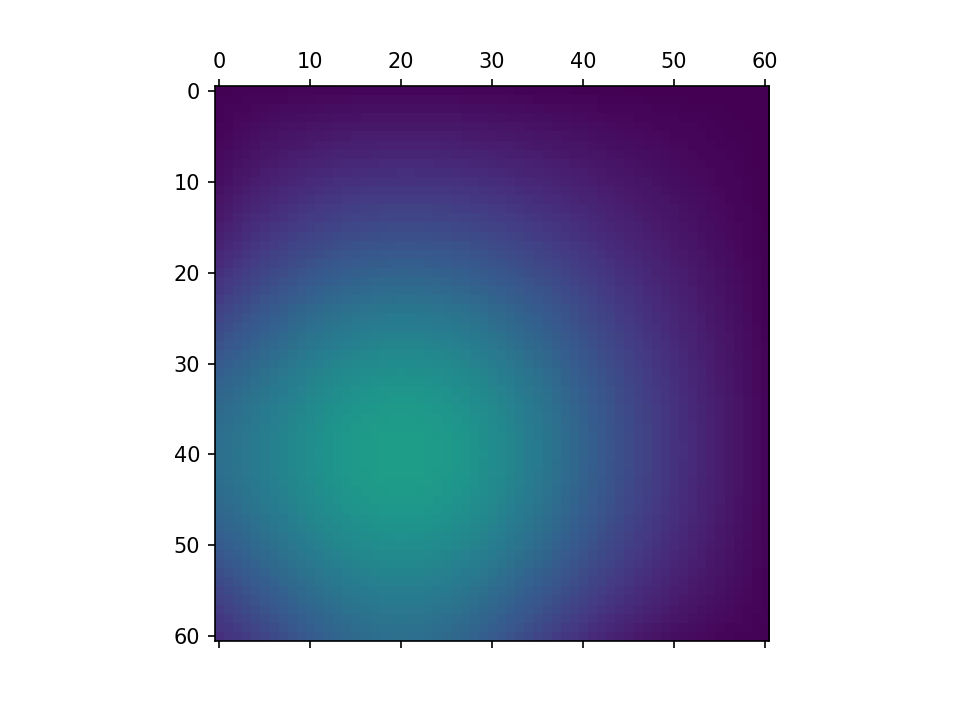

In [5]:
#remove this if running as a .py file
%matplotlib notebook

#create list of heat state at each time step
heat = [None]*Tpoints
heat[0] = unot
for t in range(Tpoints - 1) :
    reaction = np.array([apply_reaction(i) for i in heat[t]])
    #below two line accounts for 0 flux BC's
    reaction[0:points], reaction[-points:] = 0,0
    reaction[points::points], reaction[points+1::points] = 0,0
    
    
    place = np.matmul(Right, heat[t]) + reaction
    heat[t+1] = np.matmul(inv, place)
    
#initial condition  
usol = np.reshape(heat[0],(points,points))

fig, ax = plt.subplots()
matrice = ax.matshow(usol)

# update the heat at each time-step
def update_heat(n):
    usol = np.reshape(heat[n+1],(points,points))
    matrice.set_array(usol)

ani = animation.FuncAnimation(fig, update_heat, Tpoints - 1,  interval = 10)
plt.show()